# ReID Siamese Neural Network. 
Nous entrainons un réseau de neurones siamois à différentier des personnes.

## I. Importing the libraries.
Le réseau de neurone est fait avec tensorflow 2.5.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import sys
import os
import pandas as pd
import re
from itertools import combinations
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow.keras.backend as K
import random
import gc
from tensorflow.keras import callbacks, optimizers

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
from absl import app, flags, logging
from absl.flags import FLAGS

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

## 2. Flags
Des drapeaux sont créés pour les variables du programme.

In [4]:
flags.DEFINE_integer('batch_size', '150', 'batch size for training')
#tf.flags.DEFINE_integer('max_steps', '210000', 'max steps for training')
flags.DEFINE_integer('max_steps', '15005', 'max steps for training')
flags.DEFINE_string('logs_dir', 'logs/', 'path to logs directory')
flags.DEFINE_string('data_dir', 'data/', 'path to dataset')
flags.DEFINE_float('learning_rate', '0.01', '')
flags.DEFINE_string('mode', 'train', 'Mode train, val, test')
flags.DEFINE_string('image1', '', 'First image path to compare')
flags.DEFINE_string('image2', '', 'Second image path to compare')
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 160

In [5]:
# Using FLAGS.`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
    app.run(lambda argv: None)
except:
    pass

## 3. Train Test datasets.
Nous créons une série de paire d'image du même joueur et de joueur différents.

In [6]:
root = '/Users/pierreballesta/Foot/patches_save'
folders = list(os.walk(root))[1:]

for folder in folders:
    # folder example: ('FOLDER/3', [], ['file'])
    if not folder[2]:
        os.rmdir(folder[0])

In [7]:
# We create our database of images.
im_db = [x[0] for x in os.walk(root)]

In [8]:
main_dir = '/Users/pierreballesta/Foot/patches_save/'
sub_dirs = os.listdir('/Users/pierreballesta/Foot/patches_save/')
sub_dirs = [s for s in sub_dirs if 'track' in s]
images = [main_dir+s+'/'+d for s in sub_dirs for d in os.listdir(main_dir+s) if 'im' in d]

In [9]:
tracks = np.array([[int(a) for a in re.findall(r'\d+',n)] for n in images])

In [10]:
images_db = pd.DataFrame({'paths':images,'tracks':tracks[:,0],'images':tracks[:,1]})

In [11]:
# Removing empty patches:
for i in images_db.index:
    try:
        y0 = cv2.imread(images_db['paths'][i])
        y0 = cv2.resize(y0,(IMAGE_HEIGHT,IMAGE_WIDTH))
    except:
        os.remove(images_db['paths'][i])
        images_db = images_db.drop([i])

In [12]:
images_db.to_pickle('/Users/pierreballesta/Foot/players_dataframe.pkl')

In [13]:
images_db.describe()

tracks        images
count  34517.000000  34517.000000
mean      61.675638   2191.760727
std      135.875707   1334.265912
min        1.000000      0.000000
25%       10.000000   1038.000000
50%       14.000000   2144.000000
75%       31.000000   3362.000000
max      665.000000   4499.000000

In [14]:
# We create a list of same people. Patches in the same track.
list_same = []
for nu in set(images_db['tracks']):
    list_same += [a for a in combinations(images_db['paths'].loc[images_db['tracks'] == nu],2)]

In [15]:
# We create a list of different people. Patches in the same image.
list_diff = []
for nu in set(images_db['images']):
    list_diff += [a for a in combinations(images_db['paths'].loc[images_db['images'] == nu],2)]

In [16]:
labels = np.concatenate((np.ones(len(list_same)),np.zeros(len(list_diff))))

In [17]:
list_pair = list_same + list_diff

Les données sont séparées en jeux d'entrainement et de test.

In [18]:
list_train,list_test,label_train,label_test = train_test_split(list_pair,labels,test_size=0.05,random_state=450, shuffle=True,stratify=labels)

In [19]:
# The same number of positive and negative pair is used.
num_pair = 100000

In [20]:
ind_same = np.random.choice([i for i in range(len(list_train)) if label_train[i]==0],num_pair,replace=False)

In [21]:
ind_diff = np.random.choice([i for i in range(len(list_train)) if label_train[i]==1],num_pair,replace=False)

In [22]:
list_train = np.concatenate((np.array(list_train)[ind_same],np.array(list_train)[ind_diff]))

In [23]:
label_train = np.concatenate((np.array(label_train)[ind_same],np.array(label_train)[ind_diff]))

In [24]:
label_train.shape

(200000,)

In [25]:
ind_same = np.random.choice([i for i in range(len(list_test)) if label_test[i]==0],int(num_pair*0.05),replace=False)

In [26]:
ind_diff = np.random.choice([i for i in range(len(list_test)) if label_test[i]==1],int(num_pair*0.05),replace=False)

In [27]:
list_test = np.concatenate((np.array(list_test)[ind_same],np.array(list_test)[ind_diff]))

In [28]:
label_test = np.concatenate((np.array(label_test)[ind_same],np.array(label_test)[ind_diff]))

In [29]:
label_test.shape

(10000,)

In [30]:
list_train = np.array([[li,la] for li,la in zip(list_train,label_train)],dtype=object)
np.random.shuffle(list_train)

In [31]:
list_test = np.array([[li,la] for li,la in zip(list_test,label_test)],dtype=object)
np.random.shuffle(list_test)

In [32]:
del list_pair,list_same,list_diff

In [33]:
list_train[:,1] = [int(c) for c in list_train[:,1]]
list_test[:,1] = [int(c) for c in list_test[:,1]]

In [34]:
# Class weights to prevent metastable solutions. Not used here.
def c_weights(data,n=3/4):
    Cy = Counter(data)
    A = len(Cy)/sum(z**(-n) for z in Cy.values())
    cw = {z:A*Cy[z]**(-n) for z in Cy}
    return cw

In [35]:
# We create the entries to the model.
# We need to enter a list of images to read.
def gen_train():
    np.random.shuffle(list_train)
    for y in list_train:
        y0 = cv2.imread(y[0][0])
        y0 = cv2.resize(y0,(IMAGE_HEIGHT,IMAGE_WIDTH))
        y1 = cv2.imread(y[0][1])
        y1 = cv2.resize(y1,(IMAGE_HEIGHT,IMAGE_WIDTH))
        label = y[1]
        yield y0,y1,[label]

def treat_im(y):
    y = tf.image.random_flip_left_right(y)
    y = tf.image.random_brightness(y, max_delta=32. / 255.)
    y = tf.image.random_saturation(y, lower=0.5, upper=1.5)
    y = tf.image.random_hue(y, max_delta=0.2)
    y = tf.image.random_contrast(y, lower=0.5, upper=1.5)
    y = tf.image.per_image_standardization(y)
    return y

def treat_pair(y0,y1,label):
    y0 = treat_im(y0)
    y1 = treat_im(y1)
    return tf.stack([y0,y1]),label
    
ds_train1 = tf.data.Dataset.from_generator(gen_train,output_signature=(tf.TensorSpec(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(1,), dtype=tf.uint8))
                                          )
ds_train1 = ds_train1.map(treat_pair, num_parallel_calls=AUTOTUNE)

ds_train1 = ds_train1.batch(
    64, drop_remainder=False, num_parallel_calls=AUTOTUNE, deterministic=False
)
ds_train1 = ds_train1.prefetch(2)

Metal device set to: Apple M1


2021-07-04 14:56:02.710356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-04 14:56:02.710748: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
# We create the entries to the model.
# We need to enter a list of images to read.
def gen_test():
    for y in list_test:
        y0 = cv2.imread(y[0][0])
        y0 = cv2.resize(y0,(IMAGE_HEIGHT,IMAGE_WIDTH))
        y1 = cv2.imread(y[0][1])
        y1 = cv2.resize(y1,(IMAGE_HEIGHT,IMAGE_WIDTH))
        label = y[1]
        yield y0,y1,[label]

def test_im(y):
    y = tf.image.per_image_standardization(y)
    return y

def test_pair(y0,y1,label):
    y0 = test_im(y0)
    y1 = test_im(y1)
    return tf.stack([y0,y1]),label
    
ds_test1 = tf.data.Dataset.from_generator(gen_test,output_signature=(tf.TensorSpec(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), dtype=tf.float32),
                                                                 tf.TensorSpec(shape=(1,), dtype=tf.uint8))
                                          )
ds_test1 = ds_test1.map(test_pair, num_parallel_calls=AUTOTUNE)

ds_test1 = ds_test1.batch(
    8, drop_remainder=False, num_parallel_calls=AUTOTUNE, deterministic=True
)

## 4. Siamese network.
Un réseau siamois basé sur la convolution est créé pour comparer les patchs.

In [37]:
def create_siamese(l2=0.0001):
      ## smooth decrease of the size of the layer
    # First treatment of the data.
    conv1_1 = tf.keras.layers.Conv2D(20, [5, 5], activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2), name='conv1_1')
    conv1_2 = tf.keras.layers.Conv2D(25, [5, 5], activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2), name='conv1_2')
    conv1_3 = tf.keras.layers.Conv2D(25, [3, 3], activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2), name='conv1_3')
    conv1_4 = tf.keras.layers.Conv2D(25, [3, 3], activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2), name='conv1_4')
    dense1 = tf.keras.layers.Dense(128, activation=None,
            kernel_regularizer=tf.keras.regularizers.l2(l2), name='dense1')

    I1 = tf.keras.layers.Input(shape=(2,IMAGE_WIDTH,IMAGE_HEIGHT,3),name='image_1')
    
    X1,X2 = tf.unstack(I1, num=None, axis=1, name='unstack')

    X1 = conv1_1(X1)
    X2 = conv1_1(X2)

    X1 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool1_1')(X1)
    X2 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool2_1')(X2)

    X1 = conv1_2(X1)
    X2 = conv1_2(X2)

    X1 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool1_2')(X1)
    X2 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool2_2')(X2)

    X1 = conv1_3(X1)
    X2 = conv1_3(X2)

    X1 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool1_3')(X1)
    X2 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool2_3')(X2)
    
    X1 = conv1_4(X1)
    X2 = conv1_4(X2)

    X1 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool1_4')(X1)
    X2 = tf.keras.layers.MaxPool2D([2, 2], [2, 2], name='pool2_4')(X2)

    X1 = tf.keras.layers.Flatten()(X1)
    X2 = tf.keras.layers.Flatten()(X2)

    X1 = dense1(X1)
    X2 = dense1(X2)

    D1 = tf.math.subtract(X1, X2, name=None)
    D1 = tf.math.square(D1)

    X = tf.keras.layers.Dense(128, activation='tanh')(D1)
    X = tf.keras.layers.Dense(1, activation='sigmoid')(X)

      # Outputs.
    module = tf.keras.Model(inputs=I1,outputs=X)
    return module

In [38]:
tutu = create_siamese()

In [39]:
tutu.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            [(None, 2, 60, 160,  0                                            
__________________________________________________________________________________________________
tf.unstack (TFOpLambda)         [(None, 60, 160, 3), 0           image_1[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 56, 156, 20)  1520        tf.unstack[0][0]                 
                                                                 tf.unstack[0][1]                 
__________________________________________________________________________________________________
pool1_1 (MaxPooling2D)          (None, 28, 78, 20)   0           conv1_1[0][0]                

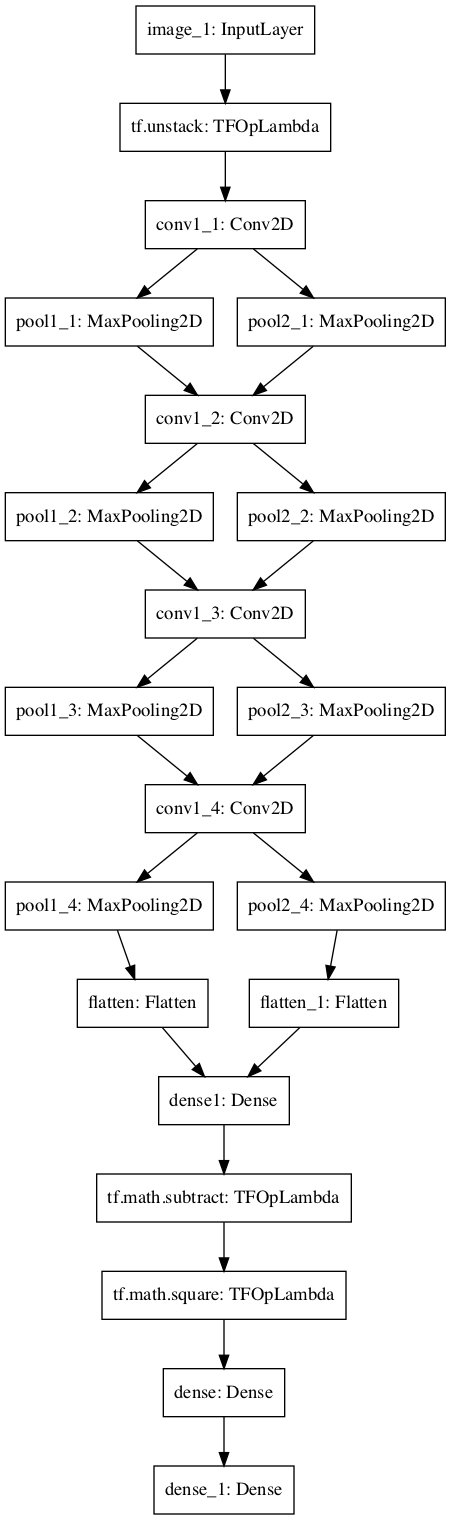

In [40]:
tf.keras.utils.plot_model(tutu)

In [41]:
# Creating the callbacks
stopNan = tf.keras.callbacks.TerminateOnNaN()

checkpoint = tf.keras.callbacks.ModelCheckpoint("/Users/pierreballesta/Foot/Temp1_siamese.h5", monitor='val_loss', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch',save_weights_only=True)

# We create a callback to stop training if the validity metrics does not deacrease for 4 epochs.
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0,
    mode='min', baseline=None, restore_best_weights=False)

def scheduler(epoch,lr):
    if epoch>0:
        return tf.math.divide(lr,1.0475)
    else :
        return lr
    
schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [42]:
myCallBacks = [schedule,stopNan,early_stop,checkpoint]

In [43]:
# loading pretrained network.
tutu = tf.keras.models.load_model("/Users/pierreballesta/Foot/Siamese")

In [44]:
tutu.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.3*1e-4),loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalseNegatives()])

In [ ]:
tutu.fit(ds_train1,epochs=24,validation_data=ds_test1,callbacks=myCallBacks)

2021-07-04 14:56:03.834170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-04 14:56:03.834316: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/24


2021-07-04 14:56:04.184596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   3125/Unknown - 461s 147ms/step - loss: 0.0648 - binary_accuracy: 0.9858 - false_negatives: 1468.0000

2021-07-04 15:03:44.900137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3125/3125 [==============================] - 475s 152ms/step - loss: 0.0648 - binary_accuracy: 0.9858 - false_negatives: 1468.0000 - val_loss: 0.0559 - val_binary_accuracy: 0.9895 - val_false_negatives: 58.0000

Epoch 00001: val_loss improved from inf to 0.05594, saving model to /Users/pierreballesta/Foot/Temp1_siamese.h5
Epoch 2/24
3125/3125 [==============================] - 474s 152ms/step - loss: 0.0613 - binary_accuracy: 0.9868 - false_negatives: 1289.0000 - val_loss: 0.0555 - val_binary_accuracy: 0.9895 - val_false_negatives: 58.0000

Epoch 00002: val_loss improved from 0.05594 to 0.05549, saving model to /Users/pierreballesta/Foot/Temp1_siamese.h5
Epoch 3/24
3125/3125 [==============================] - 474s 152ms/step - loss: 0.0600 - binary_accuracy: 0.9876 - false_negatives: 1229.0000 - val_loss: 0.0541 - val_binary_accuracy: 0.9899 - val_false_negatives: 57.0000

Epoch 00003: val_loss improved from 0.05549 to 0.05405, saving model to /Users/pierreballesta/Foot/Temp1_siamese.h

In [ ]:
gc.collect()

In [ ]:
tf.keras.models.save_model(tutu, "/Users/pierreballesta/Foot/Siamese")

In [ ]:
(1/1.0475)**100
